# Adversarial Network Tuning

Definitions:
* Network parameters: $\Theta$
* CLgen model: $G(\Theta)$
* Discriminator model: $D(G(\Theta))$

From candidate params $\Theta = \{\Theta_1, \Theta_2, \ldots, \Theta_n\}$,
find the params $\Theta_{i}$ which minimize accuracy of the discriminator.

Discriminator functions:
* Human-or-robot? Distinguish between programs from GitHub and synthesized codes.
* Is it *useful*? Determine closest distance to benchmark features (would have to be a different set of benchmarks).


1. $\epsilon = 0.05$
1. $\Theta = newParams()$
1. while $abs(D(G(\Theta)) - 0.5) > \epsilon$
1. `    ` $\Theta = newParams()$

## GitHub Corpus

In [1]:
from clgen.corpus import Corpus

corpus = Corpus.from_json({
    "path": "~/data/github",
    "vocabulary": "greedy"
})
corpus

corpus of 3950 files

In [2]:
import sqlite3

def corpus_iter(kernels_db):
    """ fetch preprocessed source codes """
    db = sqlite3.connect(kernels_db)
    c = db.cursor()
    c.execute("SELECT contents FROM PreprocessedFiles WHERE status=0")
    srcs = [row[0] for row in c.fetchall()]
    c.close()
    db.close()
    return srcs

In [3]:
import pickle
from labm8 import fs

datadir = fs.path("data", "adversarial")
fs.mkdir(datadir)

github_srcs = corpus_iter(fs.path(corpus.contentcache.path, "kernels.db"))

inpath = fs.path(datadir, "encoded-" + corpus.hash + ".pkl")
if fs.exists(inpath):
    with open(inpath, "rb") as infile:
        github_seqs = pickle.load(infile)
else:
    github_seqs = [corpus.atomizer.atomize(x) for x in github_srcs]
    with open(inpath, "wb") as outfile:
        pickle.dump(github_seqs, outfile)
        print("cached", inpath)

In [4]:
import numpy as np
import pandas as pd

lens = np.array([len(x) for x in github_seqs])
_data = [{"Percentile": x, "Sequence Length": int(round(np.percentile(lens, x)))} for x in range(0, 101, 10)]
data = pd.DataFrame(_data, columns=["Percentile", "Sequence Length"])
data

,Percentile,Sequence Length
0,0,18
1,10,57
2,20,80
3,30,116
4,40,168
5,50,266
6,60,442
7,70,782
8,80,1445
9,90,5332


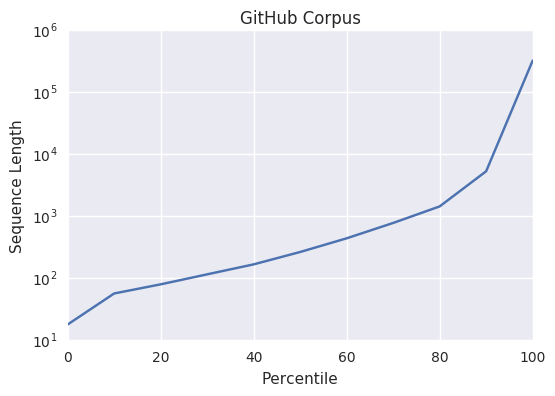

In [5]:
def isnotebook():
    try:
        shell = get_ipython().__class__.__name__
        if shell == 'ZMQInteractiveShell':  # Jupyter notebook or qtconsole?
            return True
        elif shell == 'TerminalInteractiveShell':  # Terminal running IPython?
            return False
        else:
            return False  # Other type (?)
    except NameError:
        return False      # Probably standard Python interpreter

if isnotebook():
    import matplotlib.pyplot as plt
    import seaborn as sns
    %matplotlib inline

    plt.semilogy(data["Percentile"], data["Sequence Length"])
    plt.title("GitHub Corpus")
    plt.xlabel("Percentile")
    plt.ylabel("Sequence Length")

## Synthetic Corpus

In [6]:
syn_corpus = Corpus.from_json({
    "path": "~/data/synthetic-2017-02-01",
    "vocabulary": "greedy"
})
syn_corpus

corpus of 55202 files

In [7]:
syn_srcs = corpus_iter(fs.path(syn_corpus.contentcache.path, "kernels.db"))

inpath = fs.path(datadir, "encoded-" + syn_corpus.hash + ".pkl")
if fs.exists(inpath):
    with open(inpath, "rb") as infile:
        syn_seqs = pickle.load(infile)
else:
    syn_seqs = [corpus.atomizer.atomize(x) for x in syn_srcs]
    with open(inpath, "wb") as outfile:
        pickle.dump(syn_seqs, outfile)
        print("cached", inpath)

## Discriminator Model

Encoded sequence length:

In [8]:
import scipy.stats

seq_length = 1024
p1 = scipy.stats.percentileofscore(lens, seq_length)
p2 = 100 - p1
print("""\
A sequence length of {seq_length} is the {p1:.1f}% percentile of the GitHub corpus.
{p2:.1f}% of sequences will be truncated.""".format(**vars()))

A sequence length of 1024 is the 74.9% percentile of the GitHub corpus.
25.1% of sequences will be truncated.


In [9]:
seed = 204

# inputs
vocab_size = corpus.vocab_size + 1  # pad value

# network param
embedding_vector_length = 64
lstm_size = 64

# training param
test_split = .2
validation_split = .2  # note this is the split of the training set
nb_epoch = 50
batch_size = 128

Assemble dataset:

In [21]:
# import setGPU
from keras.preprocessing.sequence import pad_sequences
import random

# shuffle sequences before truncating to nmax
nmax = min(len(github_seqs), len(syn_seqs))

random.seed(seed)
random.shuffle(github_seqs)
random.shuffle(syn_seqs)

# real_x = github_seqs[:nmax]
# fake_x = syn_seqs[:nmax]

# sanity check:
# expected outcome is 50% acc.
real_x = github_seqs[:1500]
fake_x = github_seqs[:1500]

# # sanity check no 1: 
# real_x = github_seqs[:1500]
# fake_x = syn_seqs[1500:3000]

In [22]:
# pad sequences and label '1' for synthetic, '0' for github
pad_val = vocab_size - 1

X = list(pad_sequences(real_x, maxlen=seq_length, value=pad_val))
y = [np.array([1, 0])] * len(real_x)  # 1-hot encoding

X += list(pad_sequences(fake_x, maxlen=seq_length, value=pad_val))
y += [np.array([0, 1])] * len(fake_x)  # 1-hot encoding

dataset = list(zip(X, y))
n = len(dataset)

X = np.array(X)
y = np.array(y)

print("Dataset of {n} instances ({nmax} of each type).".format(**vars()))

Dataset of 3000 instances (3950 of each type).


Split into train and test sets:

In [13]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=seed, stratify=y)

n_train = len(X_train)
n_train_gh = sum(1 if x[0] == 1 else 0 for x in y_train)
n_train_syn = sum(1 if x[1] == 1 else 0 for x in y_train)
train_syn_ratio = n_train_syn / n_train
assert(n_train_gh + n_train_syn == n_train)

n_val = int(len(X_train) * validation_split)

n_test = len(X_test)
n_test_gh = sum(1 if x[0] == 1 else 0 for x in y_test)
n_test_syn = sum(1 if x[1] == 1 else 0 for x in y_test)
test_syn_ratio = n_test_syn / n_test

print("""\
{n_train} instances for training ({n_val} of those for validation).
{n_test} instances for testing.

Ratio of synthetic codes: {train_syn_ratio:.1%} train, {test_syn_ratio:.1%} test.\
""".format(**vars()))

2400 instances for training (480 of those for validation).
600 instances for testing.

Ratio of synthetic codes: 50.0% train, 48.5% test.


Discriminator architecture:

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
code_in (InputLayer)             (None, 1024)          0                                            
____________________________________________________________________________________________________
embedding_1 (Embedding)          (None, 1024, 64)      11392       code_in[0][0]                    
____________________________________________________________________________________________________
lstm_1 (LSTM)                    (None, 1024, 64)      33024       embedding_1[0][0]                
____________________________________________________________________________________________________
lstm_2 (LSTM)                    (None, 64)            33024       lstm_1[0][0]                     
___________________________________________________________________________________________

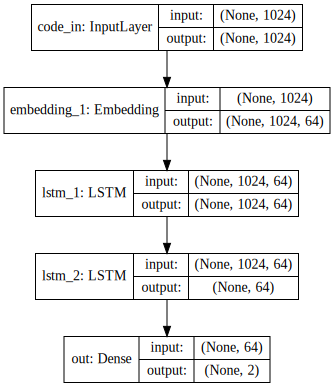

In [14]:
from keras.layers import Input, Dropout, Embedding, LSTM, Dense
from keras.models import Model, load_model
from keras.utils.visualize_util import model_to_dot
from IPython.display import SVG

def create_model():
    """ instantiate model """
    data_in = Input(shape=(2,), name="data_in")
    np.random.seed(seed)
    
    code_in = Input(shape=(seq_length,), dtype="int32", name="code_in")
    x = Embedding(output_dim=embedding_vector_length, input_dim=vocab_size, input_length=seq_length)(code_in)
    x = LSTM(lstm_size, input_dim=vocab_size, input_length=seq_length, consume_less="mem", return_sequences=True)(x)
    x = LSTM(lstm_size, consume_less="mem")(x)
    out = Dense(2, activation="sigmoid", name="out")(x)

    model = Model(input=code_in, output=out)
    model.compile(optimizer="adam", loss="categorical_crossentropy", metrics=['accuracy'])
    return model

_m = create_model()
_m.summary()
SVG(model_to_dot(_m, show_shapes=True).create(prog='dot', format='svg'))

Create and train model:

In [15]:
import clgen

train_hash = clgen.checksum(X_train.tostring() + bytes(seed))
model_path = fs.path(datadir, "model-{train_hash}.h5".format(**vars()))

if fs.exists(model_path):
    model = load_model(model_path)
else:
    model = create_model()
    np.random.seed(seed)
    model.fit(X_train, y_train, nb_epoch=nb_epoch, validation_split=validation_split,
              batch_size=batch_size, verbose=1, shuffle=True)

    model.save(model_path)
    print("cached", model_path)

Test model:

In [16]:
test_hash = clgen.checksum(X_test.tostring() + bytes(seed))
predictions_path = fs.path(datadir, "predictions-{test_hash}.pkl".format(**vars()))

if fs.exists(predictions_path):
    with open(predictions_path, "rb") as infile:
        predictions = pickle.load(infile)
else:
    predictions = np.array(model.predict(X_test, batch_size=batch_size, verbose=0))
    with open(predictions_path, "wb") as outfile:
        pickle.dump(predictions, outfile)
        print("cached", predictions_path)

Evaluate results:

In [17]:
true_syn = sum(1 for x in y_test if x[1] == 1)
true_gh = sum(1 for x in y_test if x[0] == 1)
assert(true_syn + true_gh == len(y_test))

clipped = [(0, 1) if y > x else (1, 0) for x, y in predictions]
correct = [1 if x[0] == y[0] and x[1] == y[1] else 0 for (x, y) in zip(clipped, y_test)]
n_correct = sum(correct)

score = n_correct / n_test
print("""\
Discriminator correctly classified {n_correct} of {n_test} instances ({score:.1%})\
""".format(**vars()))

Discriminator correctly classified 503 of 600 instances (83.8%)


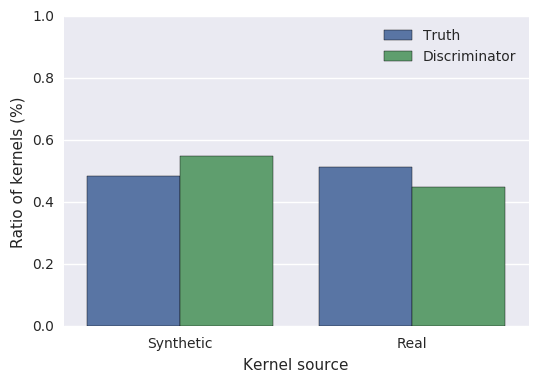

In [20]:
if isnotebook():
    data = pd.DataFrame([
        {"source": "Truth", "Kernel source": "Synthetic", "Y": sum(x[1] for x in y_test) / n_test},
        {"source": "Truth", "Kernel source": "Real", "Y": sum(x[0] for x in y_test) / n_test},
        {"source": "Discriminator", "Kernel source": "Synthetic", "Y": sum(x[1] for x in clipped) / n_test},
        {"source": "Discriminator", "Kernel source": "Real", "Y": sum(x[0] for x in clipped) / n_test},
    ])
    sns.barplot(data=data, x="Kernel source", y="Y", hue="source")
    plt.ylabel("Ratio of kernels (%)")
    plt.ylim((0, 1))
    plt.legend(title="")